In [ ]:
#dataset balancing


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, GRU, Bidirectional
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Flatten, LSTM
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from tensorflow.keras.initializers import GlorotNormal



In [3]:

class dataprep:

    def load_data(self):
        student_info = pd.read_csv("E:\\DL project\\anonymisedData\\studentInfo.csv")
        columns_to_remove = ['gender', 'region', 'highest_education', 'imd_band','age_band','studied_credits' ]
        student_info = student_info.drop(columns = columns_to_remove)
        #student_info.head()

        student_assessment = pd.read_csv("E:\\DL project\\anonymisedData\\studentAssessment.csv")
        student_assessment = student_assessment.drop(columns = 'is_banked')
        #student_assessment.head()

        assessments = pd.read_csv("E:\\DL project\\anonymisedData\\assessments.csv")
        #assessment.head()

        return student_assessment, student_info, assessments


    #produces course-wise dataframes for each student's evaluations
    def sort_data(self, course):
        student_assessment, student_info, assessments = self.load_data()

        df = pd.DataFrame()
        df['id_student'] = student_info['id_student']
        df['disability'] = student_info['disability']

        filtered_course_result = student_info[student_info['code_module']== course]
        results = filtered_course_result['final_result']
        df['final_results'] = results

        filtered_assessments = assessments[assessments['code_module'] == course]
        list_assessments = filtered_assessments['id_assessment'].unique().tolist()
        #print(list_assessments)

        filtered_assessments = assessments[assessments['code_module'] == course]
        list_presentations = filtered_assessments['code_presentation'].unique().tolist()
        #print(list_presentations)

        #drop everything but this course
        filtered_st_assessments = student_assessment[student_assessment['id_assessment'].isin(list_assessments)]

        pivoted_st_assessments = filtered_st_assessments.pivot(index='id_student', columns='id_assessment', values='score').reset_index()
        pivoted_st_assessments.fillna(0, inplace=True)

        pivoted_st_assessments.head(200)

        df = pd.merge(df, pivoted_st_assessments, on='id_student', how='left')
        df.dropna(subset=['final_results'], inplace=True)

        df.fillna(0, inplace = True)

        #print(df.head())

        return df, list_assessments, list_presentations
    
    
    def update_assessment_list(self, df):
        column_names = df.columns.tolist()
        assessment_cols =  column_names[3:]

        return assessment_cols


    #as the name implies, it calculates the relevant averages for each course and puts them in a dataframe for the final score and score classes
    #def calculate_totals(self, df):
    
    def calculate_scores(self, course ):
        df, list_assess, list_pres = self.sort_data(course)
        assess_cols= self.update_assessment_list(df)

        #calculate average scores for each student

        df['average_score'] = df[assess_cols].mean(axis=1)
        final_results_scores = {"Distinction":2,"Pass": 1, "Fail": -1, "Withdrawn": 0}
        df['final_results'] = df['final_results'].map(final_results_scores)
        disability_status = {"Y":1 ,"N":0}
        df['disability'] = df['disability'].map(disability_status)

        df['total_score'] = (0.5 * df['final_results']) + (0.3 * df['disability']) + (0.2 * df['average_score'])

        #diving data into classes
        new_score_ranges = [(-1, 2), (3, 7), (8, 12), (13, 17), (18, 21)]  
        class_labels = [1, 2, 3, 4, 5]
        df['score_class'] = pd.cut(df['total_score'], bins=[range[0] for range in new_score_ranges] + [max(new_score_ranges[-1])], labels= class_labels)

        #dropping irrelevant columns
        first_three_cols = df.iloc[:, :3]

        # Get the last three columns
        last_three_cols = df.iloc[:, -3:]

        # Create a new DataFrame with the selected columns
        new_df = pd.concat([first_three_cols, last_three_cols], axis=1)

        return new_df

        #print(new_df)


    def create_final_dataset(self):
        #loading courses
        courses = pd.read_csv("E:\\DL project\\anonymisedData\\courses.csv")
        courses = courses.drop(columns = 'module_presentation_length')

        unique_course_modules = courses['code_module'].unique()

        final_df = pd.DataFrame()


        for course_module in unique_course_modules:
            final_df = pd.concat([final_df, self.calculate_scores(course_module)], ignore_index=True)

        #print(final_df)

        return final_df
    
    
    
    def visualize_data(self):
        df = self.create_final_dataset()

        class_labels = [1,2,3,4,5]

        #class wise visualization
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='score_class', y='average_score', data=df, order=class_labels)
        plt.title('Distribution of Average Scores in Each Class')
        plt.xlabel('Score Class')
        plt.ylabel('Average Score')
        plt.show()

        #histogram
        plt.figure(figsize=(10, 6))
        plt.hist(df['total_score'], bins=30, color='skyblue', edgecolor='black')
        plt.title('Distribution of Final Scores')
        plt.xlabel('Final Score')
        plt.ylabel('Frequency')
        plt.show()

        #numeric class distribution
        plt.figure(figsize=(10, 6))
        plt.hist(df['total_score'], bins=5, color='lightcoral', edgecolor='black')
        plt.title('Distribution of Final Scores (Numeric Classes)')
        plt.xlabel('Numeric Class')
        plt.ylabel('Frequency')
        plt.show()

        #visualizing class imbalances
        class_distribution = df['score_class'].value_counts()

        # Plotting a bar chart
        plt.bar(class_distribution.index, class_distribution.values, color='skyblue')
        plt.xlabel('Score Class')
        plt.ylabel('Count')
        plt.title('Distribution of Score Classes')
        plt.show()


In [4]:
#creating the final dataset

data_p = dataprep()
data = data_p.create_final_dataset()
#data_p.visualize_data()
#print(data['score_class'].value_counts())


In [5]:

summary = data.describe()
print(summary)

         id_student    disability  final_results  average_score   total_score
count  3.259300e+04  32593.000000   32593.000000   32593.000000  32593.000000
mean   7.066877e+05      0.097076       0.348449      13.898110      2.982969
std    5.491673e+05      0.296066       0.919429      11.772136      2.651764
min    3.733000e+03      0.000000      -1.000000       0.000000     -0.500000
25%    5.085730e+05      0.000000       0.000000       2.166667      0.300000
50%    5.903100e+05      0.000000       0.000000      13.500000      2.833333
75%    6.444530e+05      0.000000       1.000000      22.222222      4.950000
max    2.716795e+06      1.000000       2.000000      83.600000     17.220000


Dealing with class imbalance by synthetic data generation

In [6]:
#visualizing class imbalances

def visualize_class_imbalance(df):
        class_distribution = df['score_class'].value_counts()

        # Plotting a bar chart
        plt.bar(class_distribution.index, class_distribution.values, color='skyblue')
        plt.xlabel('Score Class')
        plt.ylabel('Count')
        plt.title('Distribution of Score Classes')
        plt.show()


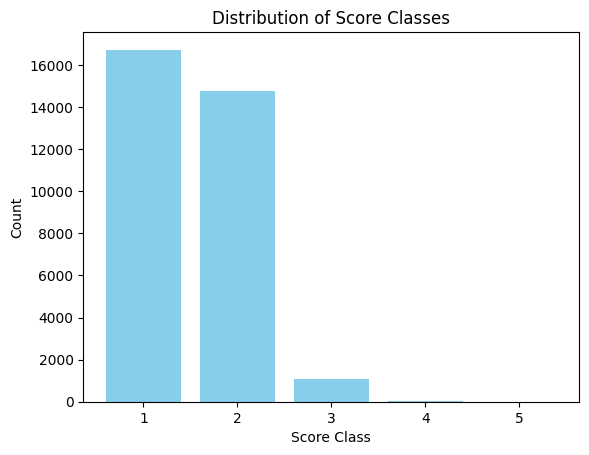

In [7]:
#original dataset (with imbalance)
visualize_class_imbalance(data)

In [8]:
#data generation for the first three columns (as they are independent)
id_student_range = (min(data['id_student']), max(data['id_student']) + 1000)  # Adding 1000 for synthetic values
disability_range = (0, 1)
final_results_range = (min(data['final_results']), max(data['final_results']))

synthetic_data = pd.DataFrame({
    'id_student': np.random.randint(id_student_range[0], id_student_range[1], size=30000),
    'disability': np.random.randint(disability_range[0], disability_range[1] + 1, size=30000),
    'final_results': np.random.randint(final_results_range[0], final_results_range[1] + 1, size=30000),
})

#data generation for the last two columns- which are dependent on the first three
synthetic_data['total_score'] = 0.5 * synthetic_data['final_results'] + 0.3 * synthetic_data['disability']

new_score_ranges = [min(synthetic_data['total_score']), max(synthetic_data['total_score'])]
class_labels = [1, 2, 3, 4, 5]
synthetic_data['score_class'] = pd.cut(synthetic_data['total_score'], bins=5, labels=class_labels)

# Drop rows with 'score_class' values 1 and 2 from synthetic_data- since there are already too many values with score_class 1 or 2
synthetic_data_filtered = synthetic_data[~synthetic_data['score_class'].isin([1,2])]

#add this data to the original dataframe
combined_data = pd.concat([data, synthetic_data_filtered], ignore_index=True)

# Display the combined data
print(combined_data['score_class'].value_counts())



score_class
1    16731
2    14747
3     8588
5     7482
4     3763
Name: count, dtype: int64


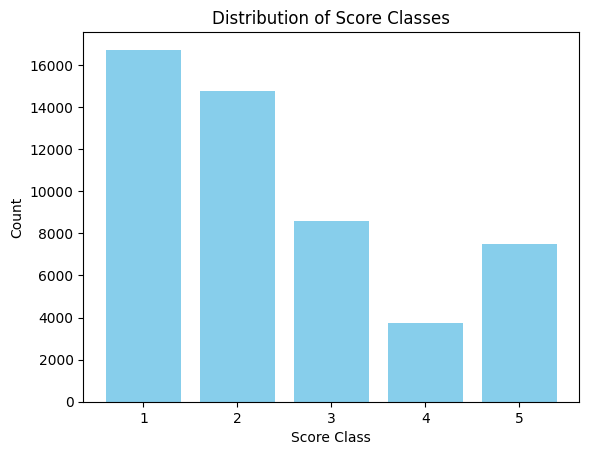

In [9]:
#reduced class imbalance
visualize_class_imbalance(combined_data)

Creating Data Sequences and Splitting it for DL models

In [10]:
def prepare_sequences(d, time_steps):
    sequences = []
    labels = []

    for i in range(len(d) - time_steps):
        seq = combined_data.iloc[i:i+time_steps][['disability', 'final_results', 'average_score', 'total_score']].values
        label = combined_data.iloc[i+time_steps]['score_class']
        sequences.append(seq)
        labels.append(label)

    return np.array(sequences), np.array(labels)

time_steps = 7
sequences, labels = prepare_sequences(combined_data, time_steps)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(sequences, labels, test_size=0.2, random_state=42)

        

In [11]:
y_train_seq -= 1
y_test_seq -= 1

#one-hot encoding for the labels
y_train_seq = to_categorical(y_train_seq, num_classes=5)
y_test_seq = to_categorical(y_test_seq, num_classes=5)

print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)

Shape of y_train_seq: (41043, 5)
Shape of y_test_seq: (10261, 5)


In [12]:
#checking for null values
print("NaN values in X_train_seq:", np.isnan(X_train_seq).any())
print("NaN values in X_test_seq:", np.isnan(X_test_seq).any())
print("Infinite values in X_train_seq:", np.isinf(X_train_seq).any())
print("Infinite values in X_test_seq:", np.isinf(X_test_seq).any())
print("NaN values in y_train_seq:", np.isnan(y_train_seq).any())
print("NaN values in y_test_seq:", np.isnan(y_test_seq).any())
print("Infinite values in y_train_seq:", np.isinf(y_train_seq).any())
print("Infinite values in y_test_seq:", np.isinf(y_test_seq).any())


NaN values in X_train_seq: True
NaN values in X_test_seq: True
Infinite values in X_train_seq: False
Infinite values in X_test_seq: False
NaN values in y_train_seq: False
NaN values in y_test_seq: False
Infinite values in y_train_seq: False
Infinite values in y_test_seq: False


In [13]:
#dealing with null values
X_train_seq = np.nan_to_num(X_train_seq, nan=np.nanmean(X_train_seq, axis=0))
X_test_seq = np.nan_to_num(X_test_seq, nan=np.nanmean(X_test_seq, axis=0))

RNNs

In [62]:
RNN_model = Sequential()
#RNN_model.add(SimpleRNN(units=64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), kernel_regularizer=l2(0.01)))
RNN_model.add(SimpleRNN(units=64, activation='relu', kernel_initializer=GlorotNormal()))

RNN_model.add(Dropout(0.1))
RNN_model.add(Dense(units=5, activation='softmax', kernel_regularizer=l2(0.01)))

# Compile the model
optimizer = Adam(learning_rate=0.001)
RNN_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
RNN_history = RNN_model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_data=(X_test_seq, y_test_seq))

Epoch 1/200
1286/1286 [==============================] - 10s 5ms/step - loss: 1.0225 - accuracy: 0.4725 - val_loss: 0.9284 - val_accuracy: 0.4957
Epoch 2/200
1286/1286 [==============================] - 9s 7ms/step - loss: 0.9037 - accuracy: 0.4974 - val_loss: 0.9052 - val_accuracy: 0.4900
Epoch 3/200
1286/1286 [==============================] - 10s 8ms/step - loss: 0.8885 - accuracy: 0.4965 - val_loss: 0.8829 - val_accuracy: 0.4940
Epoch 4/200
1286/1286 [==============================] - 12s 9ms/step - loss: 0.8806 - accuracy: 0.5016 - val_loss: 0.8730 - val_accuracy: 0.4993
Epoch 5/200
1286/1286 [==============================] - 8s 6ms/step - loss: 0.8781 - accuracy: 0.5008 - val_loss: 0.8685 - val_accuracy: 0.5035
Epoch 6/200
1286/1286 [==============================] - 10s 7ms/step - loss: 0.8776 - accuracy: 0.5024 - val_loss: 0.8745 - val_accuracy: 0.4868
Epoch 7/200
1286/1286 [==============================] - 7s 6ms/step - loss: 0.8736 - accuracy: 0.5011 - val_loss: 0.8707 - va

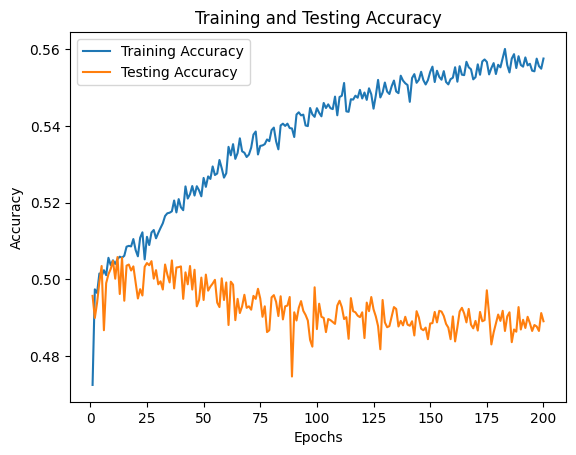

In [64]:
# Extracting accuracy values from history
train_accuracy = RNN_history.history['accuracy']
test_accuracy = RNN_history.history['val_accuracy']

# Plotting the training vs testing accuracy
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, test_accuracy, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [68]:
y_pred = RNN_model.predict(X_test_seq)
print("Shape of y_pred:", y_pred.shape)

322/322 [==============================] - 2s 4ms/step
Shape of y_pred: (10284, 5)


Accuracy: 0.4891
Precision: 0.4325
Recall: 0.4891
F1 Score: 0.4221


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


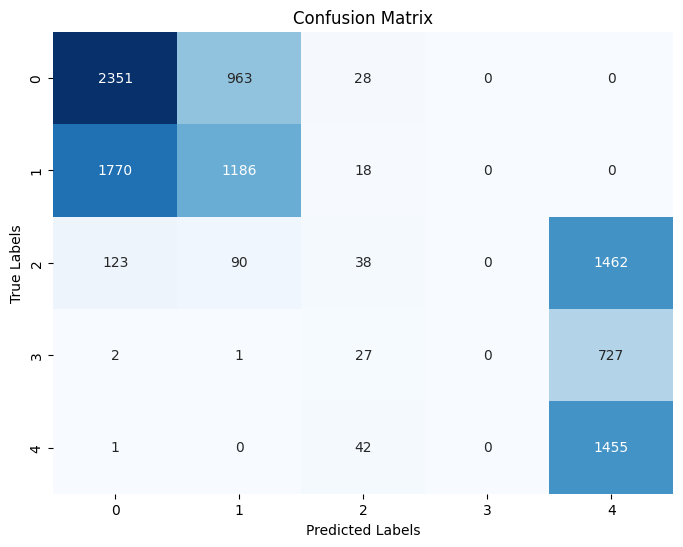

In [69]:
#evaluating the model

y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes = to_categorical(y_pred_classes, num_classes=5)

y_test_classes = y_test_seq.astype(int)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

y_test_indices = np.argmax(y_test_classes, axis=1)
y_pred_indices = np.argmax(y_pred_classes, axis=1)

conf_matrix = confusion_matrix(y_test_indices, y_pred_indices)
plt.figure(figsize= (8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

LSTMs

In [14]:
# Define the LSTM model with dropout
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.2)) 
lstm_model.add(LSTM(units=50, activation='relu', return_sequences=True))
lstm_model.add(Dropout(0.2)) 
lstm_model.add(LSTM(units=50, activation='relu'))
lstm_model.add(Dropout(0.2)) 
lstm_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
lstm_model.add(Dense(5, activation='softmax'))

optimizer = Adam(clipvalue=0.5)
lstm_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
lstm_history = lstm_model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32)


Epoch 1/200
1283/1283 [==============================] - 42s 24ms/step - loss: 1.0022 - accuracy: 0.4828
Epoch 2/200
1283/1283 [==============================] - 31s 24ms/step - loss: 0.8916 - accuracy: 0.4893
Epoch 3/200
1283/1283 [==============================] - 25s 19ms/step - loss: 0.8790 - accuracy: 0.4977
Epoch 4/200
1283/1283 [==============================] - 28s 22ms/step - loss: 0.8731 - accuracy: 0.4975
Epoch 5/200
1283/1283 [==============================] - 25s 20ms/step - loss: 0.8690 - accuracy: 0.5004
Epoch 6/200
1283/1283 [==============================] - 19s 15ms/step - loss: 0.8653 - accuracy: 0.5056
Epoch 7/200
1283/1283 [==============================] - 19s 15ms/step - loss: 0.8659 - accuracy: 0.5057
Epoch 8/200
1283/1283 [==============================] - 25s 20ms/step - loss: 0.8628 - accuracy: 0.5080
Epoch 9/200
1283/1283 [==============================] - 26s 20ms/step - loss: 0.8619 - accuracy: 0.5072
Epoch 10/200
1283/1283 [==============================]

In [15]:
y_pred = lstm_model.predict(X_test_seq)
print("Shape of y_pred:", y_pred.shape)

321/321 [==============================] - 3s 7ms/step
Shape of y_pred: (10261, 5)


Accuracy: 0.4964
Precision: 0.4324
Recall: 0.4964
F1 Score: 0.4274


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


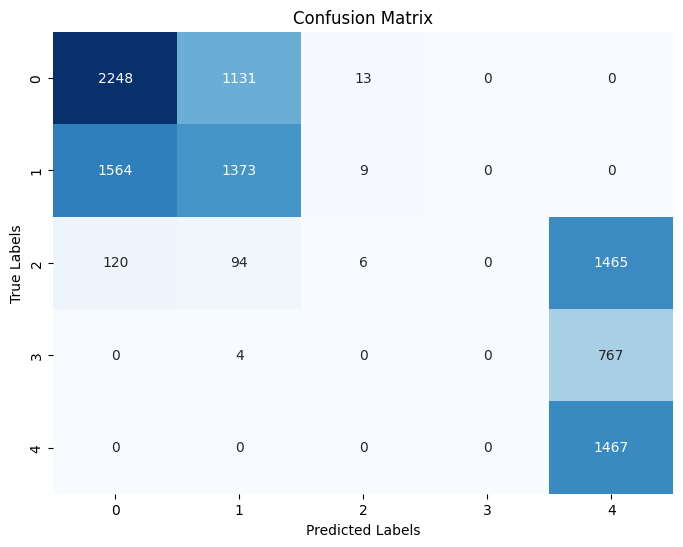

In [16]:
#evaluating the model

y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes = to_categorical(y_pred_classes, num_classes=5)


y_test_classes = y_test_seq.astype(int)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

y_test_indices = np.argmax(y_test_classes, axis=1)
y_pred_indices = np.argmax(y_pred_classes, axis=1)

conf_matrix = confusion_matrix(y_test_indices, y_pred_indices)
plt.figure(figsize= (8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Bi-LSTMs

In [19]:
Blstm_model = Sequential()
Blstm_model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
Blstm_model.add(Dropout(0.2))
Blstm_model.add(Bidirectional(LSTM(units=50)))
Blstm_model.add(Dropout(0.2))
Blstm_model.add(Dense(units=5, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
Blstm_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
Blstm_history  = Blstm_model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32)


Epoch 1/200
1283/1283 [==============================] - 54s 28ms/step - loss: 0.8924 - accuracy: 0.4931
Epoch 2/200
1283/1283 [==============================] - 38s 30ms/step - loss: 0.8646 - accuracy: 0.5018
Epoch 3/200
1283/1283 [==============================] - 39s 30ms/step - loss: 0.8609 - accuracy: 0.5088
Epoch 4/200
1283/1283 [==============================] - 30s 24ms/step - loss: 0.8597 - accuracy: 0.5074
Epoch 5/200
1283/1283 [==============================] - 29s 23ms/step - loss: 0.8566 - accuracy: 0.5091
Epoch 6/200
1283/1283 [==============================] - 29s 23ms/step - loss: 0.8561 - accuracy: 0.5103
Epoch 7/200
1283/1283 [==============================] - 37s 29ms/step - loss: 0.8545 - accuracy: 0.5092
Epoch 8/200
1283/1283 [==============================] - 31s 24ms/step - loss: 0.8532 - accuracy: 0.5095
Epoch 9/200
1283/1283 [==============================] - 23s 18ms/step - loss: 0.8539 - accuracy: 0.5050
Epoch 10/200
1283/1283 [==============================]

In [23]:
y_pred = Blstm_model.predict(X_test_seq)
print("Shape of y_pred:", y_pred.shape)

321/321 [==============================] - 7s 8ms/step
Shape of y_pred: (10261, 5)


Accuracy: 0.4820
Precision: 0.4523
Recall: 0.4820
F1 Score: 0.4657


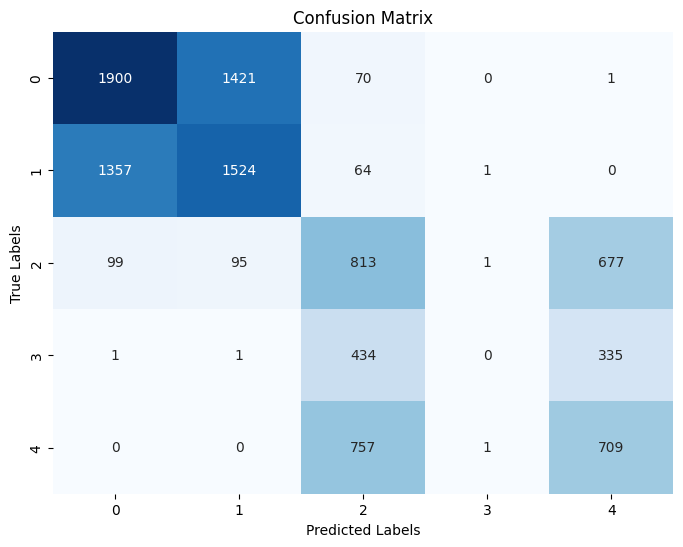

In [24]:
#evaluating the model

y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes = to_categorical(y_pred_classes, num_classes=5)

y_test_classes = y_test_seq.astype(int)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

y_test_indices = np.argmax(y_test_classes, axis=1)
y_pred_indices = np.argmax(y_pred_classes, axis=1)

conf_matrix = confusion_matrix(y_test_indices, y_pred_indices)
plt.figure(figsize= (8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

GRUs

In [26]:
#GRU definition
num_classes = 5
gru_model = Sequential()
gru_model.add(GRU(units=100, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=50, return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(Flatten())
gru_model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))
gru_model.add(Dropout(0.5))

# Output layer
gru_model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



In [27]:
#train the model
gru_history = gru_model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32)


Epoch 1/200
1283/1283 [==============================] - 35s 18ms/step - loss: 1.0547 - accuracy: 0.4751
Epoch 2/200
1283/1283 [==============================] - 22s 17ms/step - loss: 0.8906 - accuracy: 0.4882
Epoch 3/200
1283/1283 [==============================] - 24s 19ms/step - loss: 0.8837 - accuracy: 0.4909
Epoch 4/200
1283/1283 [==============================] - 25s 20ms/step - loss: 0.8832 - accuracy: 0.4920
Epoch 5/200
1283/1283 [==============================] - 25s 19ms/step - loss: 0.8814 - accuracy: 0.4952
Epoch 6/200
1283/1283 [==============================] - 25s 20ms/step - loss: 0.8785 - accuracy: 0.4949
Epoch 7/200
1283/1283 [==============================] - 25s 19ms/step - loss: 0.8770 - accuracy: 0.4960
Epoch 8/200
1283/1283 [==============================] - 26s 20ms/step - loss: 0.8774 - accuracy: 0.4992
Epoch 9/200
1283/1283 [==============================] - 26s 20ms/step - loss: 0.8745 - accuracy: 0.4985
Epoch 10/200
1283/1283 [==============================]

KeyboardInterrupt: 

In [28]:
gru_y_pred = gru_model.predict(X_test_seq)
print("Shape of y_pred:", y_pred.shape)


321/321 [==============================] - 6s 10ms/step
Shape of y_pred: (10261, 5)


Accuracy: 0.4949
Precision: 0.4017
Recall: 0.4949
F1 Score: 0.4251


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


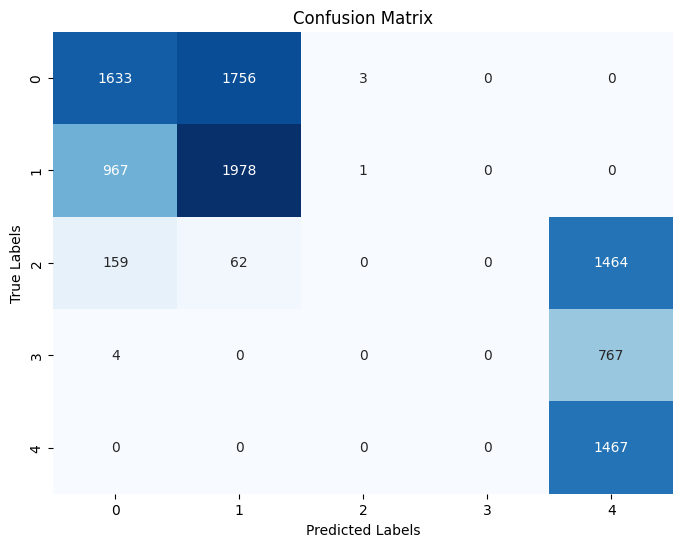

In [29]:
#evaluating the model

y_pred_classes = np.argmax(gru_y_pred, axis=1)
y_pred_classes = to_categorical(y_pred_classes, num_classes=5)

y_test_classes = y_test_seq.astype(int)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

y_test_indices = np.argmax(y_test_classes, axis=1)
y_pred_indices = np.argmax(y_pred_classes, axis=1)

conf_matrix = confusion_matrix(y_test_indices, y_pred_indices)
plt.figure(figsize= (8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()